In [2]:
from IPython.core.display import HTML,Math
def css_styling():
    styles = open("custom.css", "r").read() #or edit path to custom.css
    return HTML(styles)
css_styling()

### Importing the required functions

In [1]:
import hairbed
from hairbed import *
import subprocess
import os

# Setting Path Info
homedir = os.environ['HOME']
dropbox_path = '%s/Dropbox' % homedir
image_path = '%s/paper/images'

### Finding min edge length using CFL (Courant–Friedrichs–Lewy) condition:
<br>
CFL condition is a condition for the stability of unstable numerical methods that model convection or wave phenomena and ultimately results in the definiton of Courant number:

$$
C = \frac{U_{\mathrm{max}}\Delta t}{\Delta x}
$$

Courant number must be equal or smaller than 1, otherwise, the numerical viscosity would be negative:

$$
C \leq 1
$$

If the adjustable timestep option of OF is activated, the solver would do its best to converge the simulation, as that’s what is generally preferred.

In [2]:
Courant_number_max = 0.5
max_velocity = 2
delta_t = 1e-2
min_cell_length_x = (max_velocity*delta_t)/Courant_number_max
min_cell_length_x

0.04

minimum cell length corresponds to the cells which belong to region of fluid domain which encompasses the beam (max velocity is in $x$ direction)

### 3D problem parameters

Geometrical:

<ul>
    <li>Number of beams in $x$ direction: `num_beams_x`</li>
    <li>Number of beams in $z$ direction: `num_beams_z`</li>
    <li>Beam dimensions: `beam_t_x`,`beam_h`,`beam_t_z` ($m$)</li>
    <li>Channel dimensions: `channel_h` ($m$)</li>
    <li>Beam spacing in $x$ direction: `beam_x_spacing` ($m$)</li>
    <li>Beam spacing in $z$ direction: `beam_z_spacing` ($m$)</li>
    <li>Front and Back planes distance to beam: `side_to_wall_dist`($m$)</li>
    <li>Inlet and outlet lengths: `len_inlet`and `len_outlet` ($m$)</li>
    
</ul>

### Beam and channel dimensions:
#### Fluid domain

In [3]:
num_beams_x=6
num_beams_z=4
beam_h=0.8
channel_h=1.2
beam_t_x=0.25
beam_t_z=0.25
beam_x_spacing=0.5
beam_z_spacing=0.5
side_to_wall_dist=1
inlet_len=2
outlet_len=4
channel_l = (num_beams_x-1)*(beam_t_x+beam_x_spacing)+(inlet_len+outlet_len+beam_t_x)
channel_w =  (num_beams_z-1)*(beam_t_z+beam_z_spacing)+(2*side_to_wall_dist+beam_t_z)
xz_coeff = 0.7 # Experimental
n_cell_x_beam_fluid = int(beam_t_x/min_cell_length_x)
n_cell_z_beam_fluid = int(xz_coeff*n_cell_x_beam_fluid)
grading_x_inlet = 6
grading_x_outlet = 6
[n_cell_x_beam_fluid,n_cell_z_beam_fluid]

[6, 4]

#### Find the right number of cells for inlet/outlet

In [4]:
min_cell_inlet = 10*min_cell_length_x
min_cell_outlet = 10*min_cell_length_x
n_cell_x_inlet = 2
n_cell_x_outlet = 2

while min_cell_inlet > min_cell_length_x:
    min_cell_inlet = find_cell_dim_from_prog(grading_x_inlet,n_cell_x_inlet,inlet_len)[0]
    n_cell_x_inlet += 1
    
while min_cell_outlet > min_cell_length_x:
    min_cell_outlet = find_cell_dim_from_prog(grading_x_outlet,n_cell_x_outlet,outlet_len)[0]
    n_cell_x_outlet += 1
    
[n_cell_x_inlet,n_cell_x_outlet,min_cell_inlet,min_cell_outlet]

[19, 37, 0.0392, 0.0395]

In [5]:
grading_x_beam_fluid = 1
grading_y_beam_fluid = 3
grading_z_beam_fluid = 1
min_cell_length_y = 4*min_cell_length_x
n_cell_y_beam_fluid = 5

while min_cell_length_y > min_cell_length_x:
    min_cell_length_y_new = find_cell_dim_from_prog(grading_y_beam_fluid,n_cell_y_beam_fluid,beam_h)[0]
    n_cell_y_beam_fluid += 1
    min_cell_length_y = min_cell_length_y_new
    
[n_cell_y_beam_fluid,min_cell_length_y]

[12, 0.0396]

In [6]:
min_cell_length_gap = 4 * min_cell_length_y
gap = (channel_h-beam_h)
n_cell_y_gap = int(gap/beam_h*n_cell_y_beam_fluid)
grading_y_gap = grading_y_beam_fluid

while min_cell_length_gap > min_cell_length_y:
    n_cell_y_gap += 1
    min_cell_length_gap = find_cell_dim_from_prog(grading_y_gap,n_cell_y_gap,gap)[0]
    
[n_cell_y_gap,min_cell_length_gap]

[6, 0.0359]

In [7]:
grading_z_spacing = np.round(np.sqrt(beam_z_spacing/beam_t_z),2)
grading_x_spacing = np.sqrt(beam_x_spacing/beam_t_x)
min_cell_length_z = min_cell_length_x/xz_coeff
n_cell_x_spacing = 2
min_cell_length_x_spacing  = 4 * min_cell_length_x

while min_cell_length_x_spacing > min_cell_length_x:
    n_cell_x_spacing += 1
    min_cell_length_x_spacing = find_cell_dim_from_prog(grading_x_spacing,n_cell_x_spacing,beam_x_spacing/2)[0]

n_cell_z_spacing = 2
min_cell_length_z_spacing  = 4 * min_cell_length_z
n_cell_z_spacing = int(np.ceil((beam_z_spacing/beam_x_spacing)*n_cell_x_spacing*xz_coeff))

while min_cell_length_z_spacing > min_cell_length_z:
    n_cell_z_spacing += 1
    min_cell_length_z_spacing = find_cell_dim_from_prog(grading_z_spacing,n_cell_z_spacing,beam_z_spacing/2)[0]
n_cell_z_spacing -= 1
    
grading_z_side = 1
n_cell_z_side = int(np.ceil((side_to_wall_dist/inlet_len)*n_cell_x_inlet*xz_coeff))
min_cell_length_z_side = 4 * min_cell_length_z

while min_cell_length_z_side > min_cell_length_z:
    grading_z_side += 1
    min_cell_length_z_side = find_cell_dim_from_prog(grading_z_side,n_cell_z_side,side_to_wall_dist)[0]


[n_cell_z_side,n_cell_z_spacing,grading_z_side,grading_z_spacing]

[7, 5, 5, 1.41]

In [8]:
grading_x_beam_fluid = 1
grading_y_beam_fluid = 3
grading_z_beam_fluid = 1
min_cell_length_y = 4*min_cell_length_x
n_cell_y_beam_fluid = 5

while min_cell_length_y > min_cell_length_x:
    min_cell_length_y_new = find_cell_dim_from_prog(grading_y_beam_fluid,n_cell_y_beam_fluid,beam_h)[0]
    n_cell_y_beam_fluid += 1
    min_cell_length_y = min_cell_length_y_new
    
[n_cell_y_beam_fluid,min_cell_length_y]

[12, 0.0396]

In [9]:
min_cell_length_gap = 4 * min_cell_length_y
gap = (channel_h-beam_h)
n_cell_y_gap = int(gap/beam_h*n_cell_y_beam_fluid)
grading_y_gap = grading_y_beam_fluid

while min_cell_length_gap > min_cell_length_y:
    n_cell_y_gap += 1
    min_cell_length_gap = find_cell_dim_from_prog(grading_y_gap,n_cell_y_gap,gap)[0]
    
[n_cell_y_gap,min_cell_length_gap]

[6, 0.0359]

#### Solid domain

In [10]:
n_cell_x_beam_solid = 2 * n_cell_x_beam_fluid # Experimental
n_cell_y_beam_solid = int(np.sqrt(beam_h/beam_t_x)*n_cell_x_beam_solid)
n_cell_z_beam_solid = int(n_cell_x_beam_solid/2) # For cylinder only
grading_x_beam_solid = 1 # Not a variable
grading_y_beam_solid = 2
grading_z_beam_solid = 1 # Not a variable
min_cell_length_solid_x = np.round(beam_t_x/n_cell_x_beam_solid,4)
min_cell_length_solid_y = find_cell_dim_from_prog(grading_y_beam_solid,n_cell_y_beam_solid,beam_h)[0]
[min_cell_length_solid_x,min_cell_length_solid_y]

[0.0208, 0.0264]

## Generating Mesh

In [13]:
fluid_vertices, solid_vertices = verts3D(num_beams_x,beam_t_x,beam_x_spacing,inlet_len,outlet_len,beam_h,
                      channel_h,num_beams_z,beam_t_z,beam_z_spacing,side_to_wall_dist)

solid_blocks = blocks3DS(solid_vertices,n_cell_x_beam_solid,n_cell_y_beam_solid,
                         n_cell_z_beam_solid,grading_y_beam_solid)
fluid_blocks = blocks3DF(fluid_vertices,grading_x_inlet,grading_x_spacing,
                         grading_x_outlet,grading_y_beam_fluid,grading_y_gap,
                         grading_z_side,grading_z_spacing,n_cell_x_inlet,
                         n_cell_x_beam_fluid,n_cell_x_spacing,n_cell_x_outlet,n_cell_y_beam_fluid,
                         n_cell_y_gap,n_cell_z_side,n_cell_z_beam_fluid,n_cell_z_spacing)


writeBlockMesh(fluid_vertices,fluid_blocks,"F","3D",cylinder=True)
writeBlockMesh(solid_vertices,solid_blocks,"S","3D",cylinder=True)
blockMesh_dict = {'F':['blockMeshDictF','fluid'],'S':['blockMeshDictS','solid']}
case_path = "/Users/Ali/Dropbox/paper/test_OF"
blockMesh_path = "constant/polyMesh/blockMeshDict"
for domain in ['F','S']:
    copy_cmd = "cp %s %s/%s/%s" %(blockMesh_dict.get(domain)[0],
                                  case_path,blockMesh_dict.get(domain)[1],
                                  blockMesh_path)
    subprocess.Popen(copy_cmd, shell=True).wait()

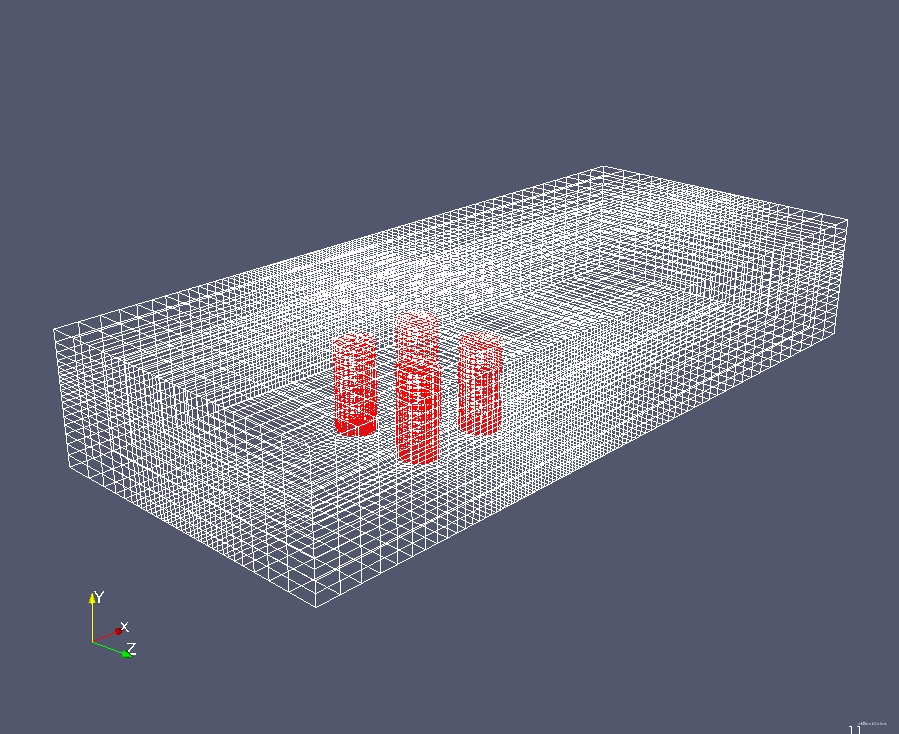

In [14]:
from IPython.display import Image
Image(filename='/Users/Ali/Dropbox/paper/images/domain.jpg', width=400, height=400)

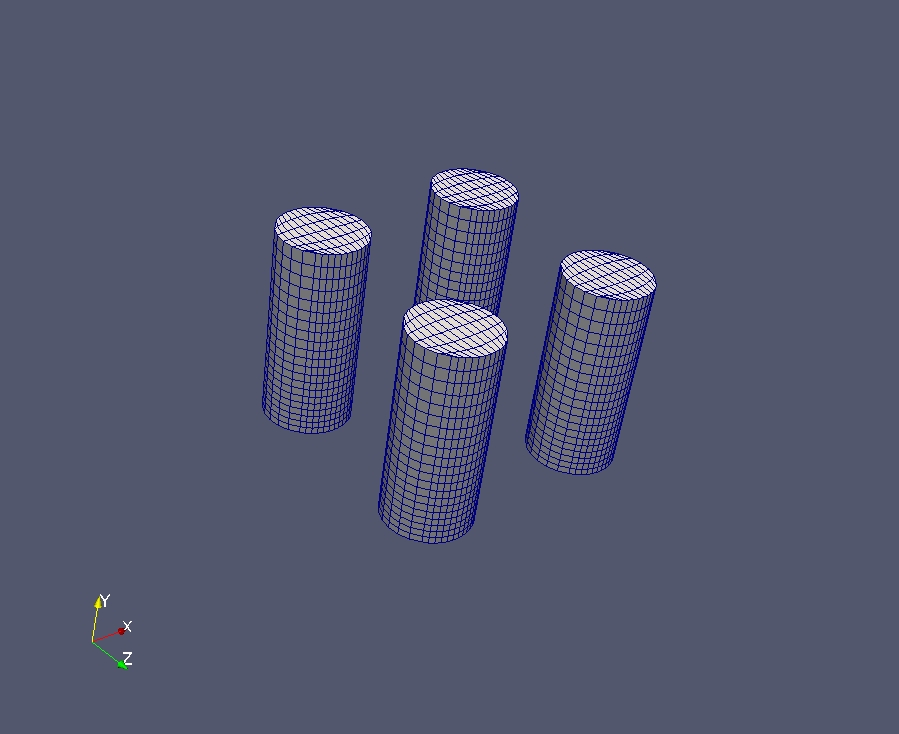

In [15]:
Image(filename='/Users/Ali/Dropbox/paper/images/solid_domain.jpg', width=400, height=400)

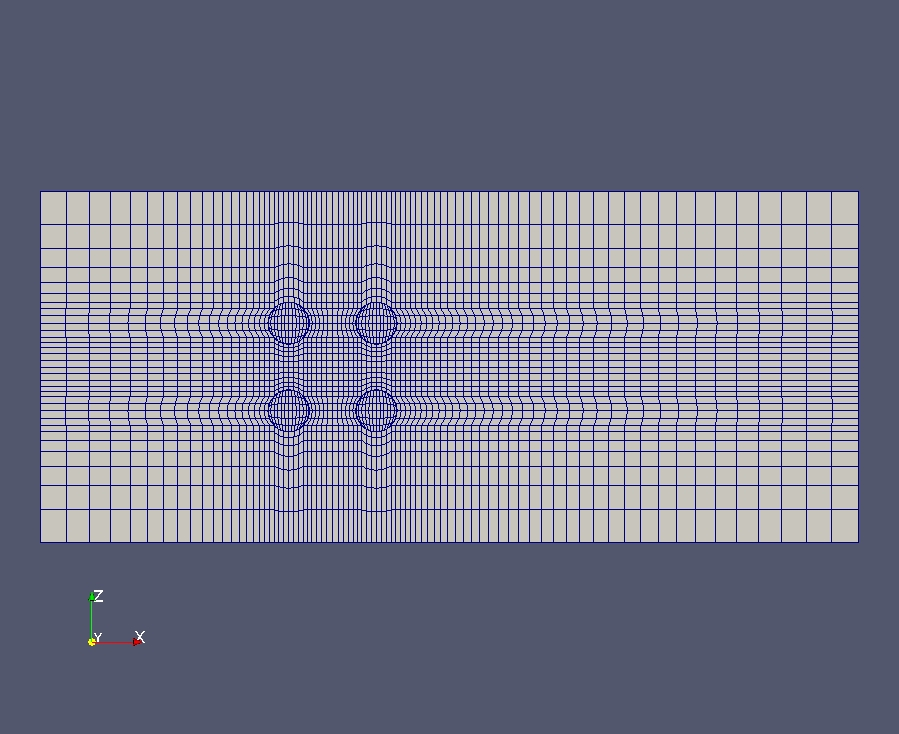

In [16]:
Image(filename='/Users/Ali/Dropbox/paper/images/domain_bottom.jpg', width=1200)

# Generating a case from scratch (3D)

## Generating a case from base case

In [58]:
cd ~/Dropbox/paper/notebook/

/Users/Ali/Dropbox/paper/notebook


In [59]:
import hairbed
from hairbed import *
import subprocess
import os
import stat
from time import sleep

# Setting Path Info
homedir = os.environ['HOME']
dropbox_path = '%s/Dropbox' % homedir
image_path = '%s/paper/images'
problem_dimension = '3D'
case_name = '%s_single_beam_full' % problem_dimension
base_case_path = "/Users/Ali/Dropbox/paper/test_OF"
case_path = "/Users/Ali/Dropbox/paper/%s" % case_name
fluid_path = os.path.join(case_path,"fluid")
solid_path = os.path.join(case_path,"solid")

# Generating a new case folder and cd to that directory
recursive_overwrite(base_case_path, case_path)
os.chdir(case_path)

sleep(5)
# changing ownership mod
for filename in os.listdir(case_path):
    if filename.endswith(".sh"):
        st = os.stat(filename)
        os.chmod(filename, st.st_mode | stat.S_IEXEC | stat.S_IXUSR | stat.S_IXGRP | stat.S_IXOTH)
        os.rename(filename, filename[:-3])
        
os.chdir(fluid_path)
for filename in os.listdir(fluid_path):
    if filename.endswith(".sh"):
        st = os.stat(filename)
        os.chmod(filename, st.st_mode | stat.S_IEXEC | stat.S_IXUSR | stat.S_IXGRP | stat.S_IXOTH)
        os.rename(filename, filename[:-3])

### Setting main variables ($Co_{max},\Delta t\,(s),U_{max}\,(\frac{m}{s})$)

In [60]:
Courant_number_max = 0.5
max_velocity = 2
delta_t = 1e-3

## fluid and solid domain mesh

### Main variables for mesh generation

In [61]:
min_cell_length_x = 3*(max_velocity*delta_t)/Courant_number_max
num_beams_x=1
num_beams_z=1
beam_h=0.8
channel_h=1.2
beam_t_x=0.05
beam_t_z=0.05
beam_x_spacing=0.5
beam_z_spacing=0.5
side_to_wall_dist=0.5
inlet_len=2
outlet_len=4
channel_l = (num_beams_x-1)*(beam_t_x+beam_x_spacing)+(inlet_len+outlet_len+beam_t_x)
channel_w =  (num_beams_z-1)*(beam_t_z+beam_z_spacing)+(2*side_to_wall_dist+beam_t_z)
xz_coeff = 0.7 
n_cell_x_beam_fluid = int(beam_t_x/min_cell_length_x)
n_cell_z_beam_fluid = int(xz_coeff*n_cell_x_beam_fluid)
grading_x_inlet = 6
grading_x_outlet = 6
min_cell_inlet = 10*min_cell_length_x
min_cell_outlet = 10*min_cell_length_x
n_cell_x_inlet = 2
n_cell_x_outlet = 2
grading_x_beam_fluid = 1
grading_y_beam_fluid = 2.5
grading_z_beam_fluid = 1
grading_x_beam_solid = 1 
grading_y_beam_solid = 2.5
grading_z_beam_solid = 1 

0.004

### variables calculated from main variables

In [62]:
while min_cell_inlet > min_cell_length_x:
    min_cell_inlet = find_cell_dim_from_prog(grading_x_inlet,n_cell_x_inlet,inlet_len)[0]
    n_cell_x_inlet += 1
    
while min_cell_outlet > min_cell_length_x:
    min_cell_outlet = find_cell_dim_from_prog(grading_x_outlet,n_cell_x_outlet,outlet_len)[0]
    n_cell_x_outlet += 1

min_cell_length_y = 4*min_cell_length_x
n_cell_y_beam_fluid = 5

while min_cell_length_y > min_cell_length_x:
    min_cell_length_y_new = find_cell_dim_from_prog(grading_y_beam_fluid,n_cell_y_beam_fluid,beam_h)[0]
    n_cell_y_beam_fluid += 1
    min_cell_length_y = min_cell_length_y_new

min_cell_length_gap = 4 * min_cell_length_y
gap = (channel_h-beam_h)
n_cell_y_gap = int(gap/beam_h*n_cell_y_beam_fluid)
grading_y_gap = grading_y_beam_fluid

while min_cell_length_gap > min_cell_length_y:
    n_cell_y_gap += 1
    min_cell_length_gap = find_cell_dim_from_prog(grading_y_gap,n_cell_y_gap,gap)[0]

grading_z_spacing = np.round(np.sqrt(beam_z_spacing/beam_t_z),2)
grading_x_spacing = np.sqrt(beam_x_spacing/beam_t_x)
min_cell_length_z = min_cell_length_x/xz_coeff
n_cell_x_spacing = 2
min_cell_length_x_spacing  = 4 * min_cell_length_x

while min_cell_length_x_spacing > min_cell_length_x:
    n_cell_x_spacing += 1
    min_cell_length_x_spacing = find_cell_dim_from_prog(grading_x_spacing,n_cell_x_spacing,beam_x_spacing/2)[0]

n_cell_z_spacing = 2
min_cell_length_z_spacing  = 4 * min_cell_length_z
n_cell_z_spacing = int(np.ceil((beam_z_spacing/beam_x_spacing)*n_cell_x_spacing*xz_coeff))

while min_cell_length_z_spacing > min_cell_length_z:
    n_cell_z_spacing += 1
    min_cell_length_z_spacing = find_cell_dim_from_prog(grading_z_spacing,n_cell_z_spacing,beam_z_spacing/2)[0]
n_cell_z_spacing -= 1
    
grading_z_side = 1
n_cell_z_side = int(np.ceil((side_to_wall_dist/inlet_len)*n_cell_x_inlet*xz_coeff))
min_cell_length_z_side = 4 * min_cell_length_z

while min_cell_length_z_side > min_cell_length_z:
    grading_z_side += 1
    min_cell_length_z_side = find_cell_dim_from_prog(grading_z_side,n_cell_z_side,side_to_wall_dist)[0]

min_cell_length_y = 4*min_cell_length_x
n_cell_y_beam_fluid = 5

while min_cell_length_y > min_cell_length_x:
    min_cell_length_y = find_cell_dim_from_prog(grading_y_beam_fluid,n_cell_y_beam_fluid,beam_h)[0]
    n_cell_y_beam_fluid += 1

min_cell_length_gap = 4 * min_cell_length_y
gap = (channel_h-beam_h)
n_cell_y_gap = int(gap/beam_h*n_cell_y_beam_fluid)
grading_y_gap = grading_y_beam_fluid

while min_cell_length_gap > min_cell_length_y:
    n_cell_y_gap += 1
    min_cell_length_gap = find_cell_dim_from_prog(grading_y_gap,n_cell_y_gap,gap)[0]

n_cell_x_beam_solid = 2 * n_cell_x_beam_fluid 
n_cell_y_beam_solid = int(np.sqrt(beam_h/beam_t_x)*n_cell_x_beam_solid)
n_cell_z_beam_solid = int(n_cell_x_beam_solid/2) # For cylinder only

### vertices, lines, face, blocks

In [63]:
angle=90
zScaling=0.5
fluid_vertices, solid_vertices = verts3D(num_beams_x,beam_t_x,beam_x_spacing,inlet_len,outlet_len,beam_h,
                      channel_h,num_beams_z,beam_t_z,beam_z_spacing,side_to_wall_dist,angle,zScaling)

solid_blocks = blocks3DS(solid_vertices,n_cell_x_beam_solid,n_cell_y_beam_solid,
                         n_cell_z_beam_solid,grading_y_beam_solid,every_other=True)
fluid_blocks = blocks3DF(fluid_vertices,grading_x_inlet,grading_x_spacing,
                         grading_x_outlet,grading_y_beam_fluid,grading_y_gap,
                         grading_z_side,grading_z_spacing,n_cell_x_inlet,
                         n_cell_x_beam_fluid,n_cell_x_spacing,n_cell_x_outlet,n_cell_y_beam_fluid,
                         n_cell_y_gap,n_cell_z_side,n_cell_z_beam_fluid,n_cell_z_spacing,zScaling)


writeBlockMesh(fluid_vertices,fluid_blocks,"F",problem_dimension,cylinder=True,every_other=False)
writeBlockMesh(solid_vertices,solid_blocks,"S",problem_dimension,cylinder=True,every_other=False)
#writeBlockMesh(fluid_vertices,fluid_blocks,"F","3D",cylinder=True,every_other=False)
#writeBlockMesh(solid_vertices,solid_blocks,"S","3D",cylinder=True,every_other=False)
blockMesh_dict = {'F':['blockMeshDictF','fluid'],'S':['blockMeshDictS','solid']}
blockMesh_path = "constant/polyMesh/blockMeshDict"
for domain in ['F','S']:
    copy_cmd = "mv %s %s/%s/%s" %(blockMesh_dict.get(domain)[0],
                                  case_path,blockMesh_dict.get(domain)[1],
                                  blockMesh_path)
    subprocess.Popen(copy_cmd, shell=True).wait()

### setting simulation type, material properties and boundary conditions<br>

#### Flow type (different B.C.):
<ul>
<li>Couette (Linear inlet velocity) `Couette_bc(max_vel,[channel_h,channel_w])`</li>
<li>Plug flow (Constant inlet velocity) `plug_bc(max_vel,[channel_h,channel_w])`</li>
<li>Pipe flow (Parabolic inlet velocity) `pipe_bc(max_vel,[channel_h,channel_w])`</li>
</ul>

#### Fluid type (different transport models):
<ul>
    <li><big>Newtonian ($\nu$)</big></li>
    <br>
        <li><big> Non-Newtonian </big></li> 
        <br>
        <ul class="fa-ul">
            
        <li>BirdCarreau ($\nu_0,\nu_{\infty},k,n$)</li>
        $$
        \nu=\nu_{\infty}+(\nu_0-\nu_{\infty})\big[{1+(k\dot{\gamma})^a}\big]^{\frac{(n-1)}{a}}
        $$
        <li>Casson ($m,\tau_0,\nu_{\mathrm{max}},\nu_{\mathrm{min}}$)</li>
        $$
          \quad \quad \quad \quad \quad \quad \quad  \quad \quad \quad \quad \quad \quad \nu=\big(\sqrt{\frac{\tau_0}{\dot{\gamma}}} + \sqrt{m}\big)^2 \quad \quad \quad \quad \quad \quad \quad \quad \nu_{\mathrm{min}} \leq \nu \leq \nu_{\mathrm{max}}
        $$
        <li>poweLaw ($\nu_{\mathrm{max}},\nu_{\mathrm{min}},k,n$)</li>
        $$
          \quad  \quad  \quad \quad \quad \quad \quad \quad\quad \quad \quad \quad \quad \quad \quad \nu = k\,\dot{\gamma}^{n-1} \quad \quad  \quad \quad \quad \quad \quad \quad \quad \quad  \nu_{\mathrm{min}} \leq \nu \leq \nu_{\mathrm{max}}
        $$
        <br>
        <li>crossPowerLaw ($\nu_0,\nu_{\infty},m,n$)</li>
        $$
        \nu=\nu_{\infty}+\frac{\nu_0-\nu_{\infty}}{1+(m\dot{\gamma})^n}
        $$
        <li>HerschelBulkley ($\nu_0,\tau_0,k,n$)</li>
        $$
        \nu = \mathrm{min}(\nu_0,\frac{\tau_0}{\dot{\gamma}}+k\,\dot{\gamma}^{n-1})
        $$
        <li>...</li>
       </ul>
</ul>

Notes:<br>
$a$ has a default values of $2$ in BirdCarreau model<br>

<ul>
<li>$\dot{\gamma}\,(\frac{1}{s})$ : shear rate</li>
<li>$\nu\,(\frac{m^2}{s})$ : kinematic viscosity</li>
<li>$\nu_0$ : kinematic viscosity at zero shear rate</li>
<li>$\nu_{Inf}$ : kinematic viscosity at infinite shear rate</li>
<li>$\nu_{min}$ : lower bound of kinematic viscosity</li>
<li>$\nu_{max}$ : upper bound of kinematic viscosity</li>
<li>$\tau_0\,(\frac{m^2}{s^2})$ : threshold stress</li>
<li>$k\,(s)$ : relaxation time</li>
<li>$n$ : power index</li>
</ul>


#### material_properties:
<ul>
<li>$\rho\,(\frac{kg}{m^3})$ : Fluid density</li>
<li>$E\,(\mathrm{Pa})$ : Elastic modulus of the beam</li>
<li>$\nu_{beam}$: Poisson's ration of the beam</li>
<li>$\rho_{beam}\,(\frac{kg}{m^3})$: Density of the beam</li>
</ul>

In [64]:
nu_0 = 1e-6
nu_inf = 1e-7
k_Carreau = 2
n_Carreau = 0.9
rho_fluid = 1e3
rho_beam = 1e3
E_beam = 1e6
nu_beam = 0.4

bc_dict = Couette_bc(max_velocity,[channel_h,channel_w],problem_dimension)
fluid_model = Newtonian(nu_0)

write_bc(bc_dict)
write_solid_rheology(rho_beam,E_beam,nu_beam,problem_dimension)
write_transport_model(fluid_model,rho_fluid)

for fluid_bc in ['pointMotionU_fl','U_fl','p_fl']:
    copy_cmd = "mv %s 0/%s" %(fluid_bc,fluid_bc[:-3])
    subprocess.Popen(copy_cmd, shell=True).wait()
    
for solid_bc in ['D','pointD']:
    copy_cmd = "mv ../solid/0/%s_%s ../solid/0/%s; rm ../solid/0/%s_*;" %(solid_bc,problem_dimension,solid_bc,solid_bc)
    subprocess.Popen(copy_cmd, shell=True).wait()

subprocess.Popen("mv rheologyProperties %s/constant/" % solid_path, shell=True).wait()
subprocess.Popen("mv transportProperties %s/constant/" % fluid_path, shell=True).wait()
if problem_dimension=="2D":
    subprocess.Popen("echo \"twoDMotion   yes;\" >> %s/constant/dynamicMeshDict" % fluid_path, shell=True).wait()

In [65]:
### setting simulation control parameters conditions<br>

commands_list = []
# controlDict parameters
t_end = 80 # seconds
write_control = 'adjustableRunTime' # 'adjustableRunTime' or 'timeStep'
write_interval = '0.2' # seconds
#if bc_dict[4] in ['pipe','Couette']:
#    commands_list.append('./write_set_inlet_velocity %s %4.2f %4.2f %4.2f' %(bc_dict[4],max_velocity,channel_h,channel_w,))
#commands_list.append('./write_control_dict %6.4f %4.2f %s %4.2f %s %s' %(delta_t,t_end,write_control,Courant_number_max,
#                                                                            write_interval,bc_dict[4]))
# decomposeParDict parameters
nx=2
ny=1
nz=2
num_domains=int(nx*ny*nz)
subprocess.Popen('chmod +x write_decompose_par_dict',shell=True).wait()
commands_list.append('./write_decompose_par_dict %d %d %d %d' %(num_domains,nx,ny,nz))

# parallel job parameters
node_constraint=0 # 0 (not constrained) or 1 (constrained)
partition=0 # 0 (maloney) or 1 (general) or 2 (gpu) or 3 (gpu_test)  
commands_list.append('./write_discovery_job_script %d %d %d' %(num_domains,node_constraint,partition))

for command in commands_list:
    subprocess.Popen(command, shell=True).wait()

In [57]:
pwd

'/Users/Ali/Dropbox/paper/3D_single_beam_full/fluid'

#### and ultimately run:<br>
`chmod +x Allset && ./Allset && ./Allrun &` for serial jobs, <br>
`chmod +x Allset && ./Allset && ./AllrunPar &` for parallel jobs, and <br>
`chmod +x Allset && ./Allset && ./AllrunParDisc &` for discovery cluster jobs <br>
from command line

# Generating a case from scratch (2D)

## Generating a case from base case

In [19]:
cd ~/Dropbox/paper/notebook/

/Users/Ali/Dropbox/paper/notebook


In [32]:
import hairbed
from hairbed import *
import subprocess
import os
import stat
from time import sleep

# Setting Path Info
homedir = os.environ['HOME']
dropbox_path = '%s/Dropbox' % homedir
image_path = '%s/paper/images'
problem_dimension = '2D'
case_name = '%s_single_beams_final' % problem_dimension
base_case_path = "/Users/Ali/Dropbox/paper/test_OF"
case_path = "/Users/Ali/Dropbox/paper/%s" % case_name
fluid_path = os.path.join(case_path,"fluid")
solid_path = os.path.join(case_path,"solid")

# Generating a new case folder and cd to that directory
recursive_overwrite(base_case_path, case_path)
os.chdir(case_path)

sleep(5)
# changing ownership mod
for filename in os.listdir(case_path):
    if filename.endswith(".sh"):
        st = os.stat(filename)
        os.chmod(filename, st.st_mode | stat.S_IEXEC | stat.S_IXUSR | stat.S_IXGRP | stat.S_IXOTH)
        os.rename(filename, filename[:-3])
        
os.chdir(fluid_path)
for filename in os.listdir(fluid_path):
    if filename.endswith(".sh"):
        st = os.stat(filename)
        os.chmod(filename, st.st_mode | stat.S_IEXEC | stat.S_IXUSR | stat.S_IXGRP | stat.S_IXOTH)
        os.rename(filename, filename[:-3])

### Setting main variables ($Co_{max},\Delta t\,(s),U_{max}\,(\frac{m}{s})$)

In [64]:
Courant_number_max = 0.5
max_velocity = 2
delta_t = 5e-3

## fluid and solid domain mesh

### Main variables for mesh generation

In [65]:
beam_h=0.4 # 0.6 0.4
channel_h=1.2
min_cell_length_x = (max_velocity*delta_t)/Courant_number_max
num_beams_x=1
beam_t_x=0.05
beam_x_spacing=0.5
inlet_len=3
outlet_len=6
channel_l = (num_beams_x-1)*(beam_t_x+beam_x_spacing)+(inlet_len+outlet_len+beam_t_x)
channel_w = 0.5
n_cell_x_beam_fluid = int(beam_t_x/min_cell_length_x)
grading_x_inlet = inlet_len*5*max_velocity
grading_x_outlet = inlet_len*4*max_velocity
min_cell_inlet = 10*min_cell_length_x
min_cell_outlet = 10*min_cell_length_x
n_cell_x_inlet = 2
n_cell_x_outlet = 2
grading_x_beam_fluid = 1
grading_y_beam_fluid = 3
grading_x_beam_solid = 1 
grading_y_beam_solid = 1

In [66]:
min_cell_length_x

0.02

### variables calculated from main variables

In [39]:
while min_cell_inlet > min_cell_length_x:
    min_cell_inlet = find_cell_dim_from_prog(grading_x_inlet,n_cell_x_inlet,inlet_len)[0]
    n_cell_x_inlet += 1
    
while min_cell_outlet > min_cell_length_x:
    min_cell_outlet = find_cell_dim_from_prog(grading_x_outlet,n_cell_x_outlet,outlet_len)[0]
    n_cell_x_outlet += 1

min_cell_length_y = 2*min_cell_length_x
n_cell_y_beam_fluid = 5

while min_cell_length_y > min_cell_length_x:
    min_cell_length_y = find_cell_dim_from_prog(grading_y_beam_fluid,n_cell_y_beam_fluid,beam_h)[0]
    n_cell_y_beam_fluid += 1

while min_cell_length_gap > min_cell_length_y:
    n_cell_y_gap += 1
    min_cell_length_gap = find_cell_dim_from_prog(grading_y_gap,n_cell_y_gap,gap)[0]

grading_x_spacing = np.sqrt(beam_x_spacing/beam_t_x)
n_cell_x_spacing = 2
min_cell_length_x_spacing  = min_cell_length_x

while min_cell_length_x_spacing > min_cell_length_x:
    n_cell_x_spacing += 1
    min_cell_length_x_spacing = find_cell_dim_from_prog(grading_x_spacing,n_cell_x_spacing,beam_x_spacing/2)[0]


min_cell_length_gap = 4 * min_cell_length_y
gap = (channel_h-beam_h)
n_cell_y_gap = int(gap/beam_h*n_cell_y_beam_fluid)
grading_y_gap = grading_y_beam_fluid

while min_cell_length_gap > min_cell_length_y:
    n_cell_y_gap += 1
    min_cell_length_gap = find_cell_dim_from_prog(grading_y_gap,n_cell_y_gap,gap)[0]

n_cell_x_beam_solid = 2*n_cell_x_beam_fluid 
n_cell_y_beam_solid = np.round(n_cell_y_beam_fluid*1.2)
#min_cell_length_solid_x = np.round(beam_t_x/n_cell_x_beam_solid,4)
#min_cell_length_solid_y = find_cell_dim_from_prog(grading_y_beam_solid,n_cell_y_beam_solid,beam_h)[0]

In [63]:
min_cell_inlet = find_cell_dim_from_prog(60,50,3)[0]
min_cell_inlet#,n_cell_x_inlet,grading_x_inlet

0.0041

In [25]:
n_cell_x_beam_solid,n_cell_y_beam_solid,n_cell_x_beam_fluid,n_cell_y_beam_fluid
n_cell_y_beam_solid = 30
n_cell_y_beam_fluid = 20

### vertices, lines, face, blocks

In [31]:
grading_x_inlet

6

In [28]:
angle=90
fluid_vertices, solid_vertices = verts2D(beam_t_x, beam_h, channel_w,channel_h,\
                                         inlet_len, outlet_len, num_beams_x, beam_x_spacing,angle)

solid_blocks = blocks2DS(solid_vertices, n_cell_x_beam_solid, n_cell_y_beam_solid,\
                         grading_y_beam_solid)

fluid_blocks = blocks2DF(fluid_vertices,grading_x_inlet,grading_x_spacing,\
                         grading_x_outlet,grading_y_beam_fluid,grading_y_gap,\
                         n_cell_x_inlet,n_cell_x_beam_fluid,n_cell_x_spacing,\
                         n_cell_x_outlet,n_cell_y_beam_fluid,n_cell_y_gap)


writeBlockMesh(fluid_vertices,fluid_blocks,"F","2D")
writeBlockMesh(solid_vertices,solid_blocks,"S","2D")

blockMesh_dict = {'F':['blockMeshDictF','fluid'],'S':['blockMeshDictS','solid']}
blockMesh_path = "constant/polyMesh/blockMeshDict"
for domain in ['F','S']:
    copy_cmd = "mv %s %s/%s/%s" %(blockMesh_dict.get(domain)[0],
                                  case_path,blockMesh_dict.get(domain)[1],
                                  blockMesh_path)
    subprocess.Popen(copy_cmd, shell=True).wait()

### setting simulation type, material properties and boundary conditions<br>

#### Flow type (different B.C.):
<ul>
<li>Couette (Linear inlet velocity) `Couette_bc(max_vel,[channel_h,channel_w])`</li>
<li>Plug flow (Constant inlet velocity) `plug_bc(max_vel,[channel_h,channel_w])`</li>
<li>Pipe flow (Parabolic inlet velocity) `pipe_bc(max_vel,[channel_h,channel_w])`</li>
</ul>

#### Fluid type (different transport models):
<ul>
    <li><big>Newtonian ($\nu$)</big></li>
    <br>
        <li><big> Non-Newtonian </big></li> 
        <br>
        <ul class="fa-ul">
            
        <li>BirdCarreau ($\nu_0,\nu_{\infty},k,n$)</li>
        $$
        \nu=\nu_{\infty}+(\nu_0-\nu_{\infty})\big[{1+(k\dot{\gamma})^a}\big]^{\frac{(n-1)}{a}}
        $$
        <li>Casson ($m,\tau_0,\nu_{\mathrm{max}},\nu_{\mathrm{min}}$)</li>
        $$
          \quad \quad \quad \quad \quad \quad \quad  \quad \quad \quad \quad \quad \quad \nu=\big(\sqrt{\frac{\tau_0}{\dot{\gamma}}} + \sqrt{m}\big)^2 \quad \quad \quad \quad \quad \quad \quad \quad \nu_{\mathrm{min}} \leq \nu \leq \nu_{\mathrm{max}}
        $$
        <li>poweLaw ($\nu_{\mathrm{max}},\nu_{\mathrm{min}},k,n$)</li>
        $$
          \quad  \quad  \quad \quad \quad \quad \quad \quad\quad \quad \quad \quad \quad \quad \quad \nu = k\,\dot{\gamma}^{n-1} \quad \quad  \quad \quad \quad \quad \quad \quad \quad \quad  \nu_{\mathrm{min}} \leq \nu \leq \nu_{\mathrm{max}}
        $$
        <br>
        <li>crossPowerLaw ($\nu_0,\nu_{\infty},m,n$)</li>
        $$
        \nu=\nu_{\infty}+\frac{\nu_0-\nu_{\infty}}{1+(m\dot{\gamma})^n}
        $$
        <li>HerschelBulkley ($\nu_0,\tau_0,k,n$)</li>
        $$
        \nu = \mathrm{min}(\nu_0,\frac{\tau_0}{\dot{\gamma}}+k\,\dot{\gamma}^{n-1})
        $$
        <li>...</li>
       </ul>
</ul>

Notes:<br>
$a$ has a default values of $2$ in BirdCarreau model<br>

<ul>
<li>$\dot{\gamma}\,(\frac{1}{s})$ : shear rate</li>
<li>$\nu\,(\frac{m^2}{s})$ : kinematic viscosity</li>
<li>$\nu_0$ : kinematic viscosity at zero shear rate</li>
<li>$\nu_{Inf}$ : kinematic viscosity at infinite shear rate</li>
<li>$\nu_{min}$ : lower bound of kinematic viscosity</li>
<li>$\nu_{max}$ : upper bound of kinematic viscosity</li>
<li>$\tau_0\,(\frac{m^2}{s^2})$ : threshold stress</li>
<li>$k\,(s)$ : relaxation time</li>
<li>$n$ : power index</li>
</ul>


#### material_properties:
<ul>
<li>$\rho\,(\frac{kg}{m^3})$ : Fluid density</li>
<li>$E\,(\mathrm{Pa})$ : Elastic modulus of the beam</li>
<li>$\nu_{beam}$: Poisson's ration of the beam</li>
<li>$\rho_{beam}\,(\frac{kg}{m^3})$: Density of the beam</li>
</ul>

In [29]:
nu_0 = 1e-6
nu_inf = 1e-7
k_Carreau = 2
n_Carreau = 0.9
rho_fluid = 1e3
rho_beam = 1e3
E_beam = 1e6
nu_beam = 0.4

bc_dict = Couette_bc(max_velocity,[channel_h,channel_w],problem_dimension)
fluid_model = Newtonian(nu_0)

write_bc(bc_dict)
write_solid_rheology(rho_beam,E_beam,nu_beam,problem_dimension)
write_transport_model(fluid_model,rho_fluid)

for fluid_bc in ['pointMotionU_fl','U_fl','p_fl']:
    copy_cmd = "mv %s 0/%s" %(fluid_bc,fluid_bc[:-3])
    subprocess.Popen(copy_cmd, shell=True).wait()
    
for solid_bc in ['D','pointD']:
    copy_cmd = "mv ../solid/0/%s_%s ../solid/0/%s; rm ../solid/0/%s_*;" %(solid_bc,problem_dimension,solid_bc,solid_bc)
    subprocess.Popen(copy_cmd, shell=True).wait()

subprocess.Popen("mv rheologyProperties %s/constant/" % solid_path, shell=True).wait()
subprocess.Popen("mv transportProperties %s/constant/" % fluid_path, shell=True).wait()
if problem_dimension=="2D":
    subprocess.Popen("echo \"twoDMotion   yes;\" >> %s/constant/dynamicMeshDict" % fluid_path, shell=True).wait()

In [30]:
### setting simulation control parameters conditions<br>

commands_list = []
# controlDict parameters
t_end = 40 # seconds
write_control = 'adjustableRunTime' # 'adjustableRunTime' or 'timeStep'
write_interval = "%s" % (t_end/200) # seconds
commands_list.append('./write_control_dict %6.4f %4.2f %s %4.2f %s %s' %(delta_t,t_end,write_control,Courant_number_max,
                                                                            write_interval,bc_dict[4]))
# decomposeParDict parameters
nx=2
ny=1
num_domains=int(nx*ny)
subprocess.Popen('chmod +x write_decompose_par_dict',shell=True).wait()
commands_list.append('./write_decompose_par_dict %d %d %d 1' %(num_domains,nx,ny))

# parallel job parameters
node_constraint=0 # 0 (not constrained) or 1 (constrained)
partition=0 # 0 (maloney) or 1 (general) or 2 (gpu) or 3 (gpu_test)  
commands_list.append('./write_discovery_job_script %d %d %d' %(num_domains,node_constraint,partition))

for command in commands_list:
    subprocess.Popen(command, shell=True).wait()


#### and ultimately run:<br>
`chmod +x Allset && ./Allset && ./Allrun &` for serial jobs, <br>
`chmod +x Allset && ./Allset && ./AllrunPar &` for parallel jobs, and <br>
`chmod +x Allset && ./Allset && ./AllrunParDisc &` for discovery cluster jobs <br>
from command line

In [87]:
cd /Users/Ali/Dropbox/paper/2D_multi_beams

/Users/Ali/Dropbox/paper/2D_multi_beams


## Many 2D Cases for paper

In [10]:
cd /Users/Ali/Dropbox/paper/notebook/

/Users/Ali/Dropbox/paper/notebook


In [11]:
import hairbed
from hairbed import *
import subprocess
import os
import stat
from time import sleep

In [12]:
cd /Users/Ali/Dropbox/paper/2D_multi_beams

/Users/Ali/Dropbox/paper/2D_multi_beams


In [13]:
number_of_beams_array = np.array([1,2,4,8]) #num_beams_x
modulii = np.array([1e6,1e7,1e9,1e12])
heights = np.array([0.4,0.6,0.8]) #beam_h
velocities = np.array([0.5,2,4])

### Constants:

In [14]:
beam_t_x = 0.05
channel_w = 0.5
channel_h = 1.2
inlet_len = 4
outlet_len = 8
beam_x_spacing = 0.25
n_cell_x_beam_solid = 20
n_cell_y_beam_solid = 60
grading_y_beam_solid = 1
grading_x_inlet = 10
grading_x_spacing = 2
grading_x_outlet = 12
grading_y_beam_fluid = 1
grading_y_gap = 1
n_cell_x_inlet = 80
n_cell_x_beam_fluid = 10
n_cell_x_spacing = 10
n_cell_x_outlet = 120
delta_t_dict = {0.5:1e-2, 2.0:5e-3, 4.0:2e-3}
end_time_dict = {0.5:120, 2.0:80, 4.0:80}
moduli_dict = {1e6:'1e6',1e7:'1e7',1e9:'1e9',1e12:'1e12'}
nu_0 = 1e-6
rho_fluid = 1e3
rho_beam = 1e3
nu_beam = 0.4
Courant_number_max = 0.5

In [15]:
homedir = os.environ['HOME']
dropbox_path = '%s/Dropbox' % homedir
image_path = '%s/paper/images'
problem_dimension = '2D'
base_case_path = "/Users/Ali/Dropbox/paper/test_OF"
base_dir = "/Users/Ali/Dropbox/paper/2D_multi_beams"

for velocity in velocities:
    for n_beams in number_of_beams_array:
        for elastic_modulus in modulii:
            for beam_h in heights:
                directory_name = "U_%s_N_%s_E_%s_h_%s" % (velocity,n_beams,\
                                                          moduli_dict.get(elastic_modulus),beam_h)
                case_path = os.path.join(base_dir,directory_name)
                #os.mkdir(case_path)
                #os.chdir(case_path)
                recursive_overwrite(base_case_path, case_path)
                os.chdir(case_path)
                fluid_path = os.path.join(case_path,"fluid")
                solid_path = os.path.join(case_path,"solid")

                sleep(5)
                # changing ownership mod
                for filename in os.listdir(case_path):
                    if filename.endswith(".sh"):
                        st = os.stat(filename)
                        os.chmod(filename, st.st_mode | stat.S_IEXEC | stat.S_IXUSR | stat.S_IXGRP | stat.S_IXOTH)
                        os.rename(filename, filename[:-3])

                os.chdir(fluid_path)
                for filename in os.listdir(fluid_path):
                    if filename.endswith(".sh"):
                        st = os.stat(filename)
                        os.chmod(filename, st.st_mode | stat.S_IEXEC | stat.S_IXUSR | stat.S_IXGRP | stat.S_IXOTH)
                        os.rename(filename, filename[:-3])

                if velocity>3:
                    bc_dict = Couette_bc_noinlet(velocity,[channel_h,channel_w],problem_dimension)
                else:
                    bc_dict = Couette_bc(velocity,[channel_h,channel_w],problem_dimension)
                fluid_model = Newtonian(nu_0)
                n_cell_y_beam_fluid = np.int(beam_h/channel_h*90)
                n_cell_y_gap = np.int((channel_h-beam_h)/channel_h*90)
                fluid_vertices, solid_vertices = verts2D(beam_t_x, beam_h, channel_w,channel_h,\
                                                         inlet_len, outlet_len, n_beams, beam_x_spacing,90)

                solid_blocks = blocks2DS(solid_vertices, n_cell_x_beam_solid, n_cell_y_beam_solid,\
                                         grading_y_beam_solid)

                fluid_blocks = blocks2DF(fluid_vertices,grading_x_inlet,grading_x_spacing,\
                                         grading_x_outlet,grading_y_beam_fluid,grading_y_gap,\
                                         n_cell_x_inlet,n_cell_x_beam_fluid,n_cell_x_spacing,\
                                         n_cell_x_outlet,n_cell_y_beam_fluid,n_cell_y_gap)   

                writeBlockMesh(fluid_vertices,fluid_blocks,"F","2D")
                writeBlockMesh(solid_vertices,solid_blocks,"S","2D")

                blockMesh_dict = {'F':['blockMeshDictF','fluid'],'S':['blockMeshDictS','solid']}
                blockMesh_path = "constant/polyMesh/blockMeshDict"
                for domain in ['F','S']:
                    copy_cmd = "mv %s %s/%s/%s" %(blockMesh_dict.get(domain)[0],
                                                  case_path,blockMesh_dict.get(domain)[1],
                                                  blockMesh_path)
                    subprocess.Popen(copy_cmd, shell=True).wait()

                write_bc(bc_dict)
                write_solid_rheology(rho_beam,elastic_modulus,nu_beam,problem_dimension)
                write_transport_model(fluid_model,rho_fluid)

                for fluid_bc in ['pointMotionU_fl','U_fl','p_fl']:
                    copy_cmd = "mv %s 0/%s" %(fluid_bc,fluid_bc[:-3])
                    subprocess.Popen(copy_cmd, shell=True).wait()

                for solid_bc in ['D','pointD']:
                    copy_cmd = "mv ../solid/0/%s_%s ../solid/0/%s; rm ../solid/0/%s_*;" %(solid_bc,problem_dimension,solid_bc,solid_bc)
                    subprocess.Popen(copy_cmd, shell=True).wait()

                subprocess.Popen("mv rheologyProperties %s/constant/" % solid_path, shell=True).wait()
                subprocess.Popen("mv transportProperties %s/constant/" % fluid_path, shell=True).wait()
                if problem_dimension=="2D":
                    subprocess.Popen("echo \"twoDMotion   yes;\" >> %s/constant/dynamicMeshDict" % fluid_path, shell=True).wait()
                commands_list = []

                # controlDict parameters
                t_end = end_time_dict.get(velocity) # seconds
                delta_t = delta_t_dict.get(velocity)
                write_control = 'adjustableRunTime' # 'adjustableRunTime' or 'timeStep'
                write_interval = "%s" % (0.2) # seconds
                commands_list.append('./write_control_dict %6.4f %4.2f %s %4.2f %s %s' %(delta_t,t_end,write_control,Courant_number_max,
                                                                                            write_interval,bc_dict[4]))
                # decomposeParDict parameters
                nx=n_beams
                ny=1
                num_domains=int(nx*ny)
                subprocess.Popen('chmod +x write_decompose_par_dict',shell=True).wait()
                commands_list.append('./write_decompose_par_dict %d %d %d 1' %(num_domains,nx,ny))

                # parallel job parameters
                node_constraint=0 # 0 (not constrained) or 1 (constrained)
                partition=0 # 0 (maloney) or 1 (general) or 2 (gpu) or 3 (gpu_test)  
                commands_list.append('./write_discovery_job_script %d %d %d' %(num_domains,node_constraint,partition))

                for command in commands_list:
                    subprocess.Popen(command, shell=True).wait()
                os.chdir(base_dir)

'2.2'

In [38]:
cd ~/Dropbox/paper/notebook/

/Users/Ali/Dropbox/paper/notebook


In [ ]:
# coding: utf-8
# Template script for FSI simulation of hairbeds 2D run
import os

#**************************************************************
#********************** Model parameters **********************
#**************************************************************

# Beam spacing (m) 
spacingX = [0.5]

# Beam height (m)
beamH = [0.5]

# Number of beams
beamsN = [1]

# Elastic modulus of the beams (Pa: kg/m/s^2)
Emoduli = ['2e5']

# Rigid beams elastic modulus (Pa: kg/m/s^2)
rigidModuli = Emoduli[-1]

# Fully developed inlet velocity profile (bool)
LinearInletVel = True

# Velocity of the top wall (m/s)
topVelocity = [3,3.75,3]

# Thickness of the hairs (m)
beamThickness = 0.02

# In order to impose the linear velocity profile at the inlet, we need to creat a table which contains
# the inlet boundary points and the corresponding velocity at each point. numPoints is the number of points
# in that table
numPoints=100

# Width of the channel (m)
wChannel = 0.1

# Height of the channel (m)
hChannel = 1.0

# Length of the inlet region (m)
lInlet = 2

# Length of the outlet region (m)
lOutlet = 8

mToNumCoeff=100
#***************************************************************
#*********************** Mesh parameters ***********************
#***************************************************************

beamYProgression = 0.25
xProgression = 0.25
inletProgression = 0.1
outletProgression = 0.06
beamXRefinementFactor = 2
                
#************************************************************
#*********************** Main Program ***********************
#************************************************************

initPath = '/home/ali1/Dropbox/OF/2DSims'
for xSpacing in spacingX:
    
    spacingPath = os.path.join(initPath,str(xSpacing))
    os.mkdir(spacingPath)
    os.chdir(spacingPath)
    
    for i in range(len(beamH)):
        
        
        hBeamPath = os.path.join(spacingPath,str(beamH[i]))
        os.mkdir(hBeamPath)
        os.chdir(hBeamPath)
        

        for nBeams in beamsN:
            
            
            nBeamPath = os.path.join(hBeamPath,str(nBeams))
            os.mkdir(nBeamPath)
            os.chdir(nBeamPath)
            
            for moduli in Emoduli:
            
                moduliPath = os.path.join(nBeamPath,str(moduli))
                os.mkdir(moduliPath)
                os.chdir(moduliPath)
                
                os.system('cp -r %s %s'% (os.path.join(initPath,'case'),moduliPath))
                os.system('cp %s %s/rheologyProperties '% (os.path.join(initPath,str(moduli)),os.path.join(moduliPath,'case','solid','constant')))
                
                if moduli != rigidModuli:
                
                    PointsF = verts2DF(beamThickness, beamH[i], wChannel, hChannel, lInlet, lOutlet, nBeams, xSpacing)
                    BlocksF = blocks2DF(PointsF, xProgression, beamYProgression,inletProgression,outletProgression, beamXRefinementFactor,mToNumCoeff)
                    PointsS = verts2DS(beamThickness, beamH[i], wChannel, lInlet, lOutlet, nBeams, xSpacing)
                    BlocksS = blocks2DS(PointsS, beamYProgression, beamXRefinementFactor,mToNumCoeff)
                
                else:
                    
                    rigidBeamThickness = (nBeams-1)*xSpacing + nBeams*beamThickness
                    PointsF = verts2DF(rigidBeamThickness, beamH[i], wChannel, hChannel, lInlet, lOutlet, 1, 0)
                    BlocksF = blocks2DF(PointsF, xProgression, beamYProgression,inletProgression,outletProgression, beamXRefinementFactor,mToNumCoeff)
                    PointsS = verts2DS(rigidBeamThickness, beamH[i], wChannel, lInlet, lOutlet, 1, 0)
                    BlocksS = blocks2DS(PointsS, beamYProgression, beamXRefinementFactor,mToNumCoeff)
                    
                writeBlockMeshFl (PointsF, BlocksF)
                writeBlockMeshS (PointsS, BlocksS)
                os.system('mv %s/blockMeshDictF %s/blockMeshDict '% (moduliPath,os.path.join(moduliPath,'case','fluid','constant','polyMesh')))
                os.system('mv %s/blockMeshDictS %s/blockMeshDict '% (moduliPath,os.path.join(moduliPath,'case','solid','constant','polyMesh')))
                
                if LinearInletVel:
                    
                    writeUInletAndPoints(topVelocity[i],numPoints,hChannel,wChannel)
                    os.system('mv %s/U %s/U '% (moduliPath,os.path.join(moduliPath,'case','fluid','constant','boundaryData','inlet','0')))
                    os.system('mv %s/points %s/points '% (moduliPath,os.path.join(moduliPath,'case','fluid','constant','boundaryData','inlet')))
                    os.system('mv %s/U_linInlet %s/U '% (os.path.join(moduliPath,'case','fluid','0'),os.path.join(moduliPath,'case','fluid','0')))
                
                else:
                    
                    os.system('mv %s/U_zeroGrad %s/U '% (os.path.join(moduliPath,'case','fluid','0'),os.path.join(moduliPath,'case','fluid','0')))
                    
                #os.system('cp blockMeshDict* tmp/%d' % i)
                # Params info (writes to info.txt)
                info = "beamThickness = %s \nhBeam = %s\n\
                wChannel = %s \hChannel = %s \n\
                lInlet = %s \nlOutlet = %s \n\
                nBeams = %s \nxSpacing = %s \nbeamYProgression = %s \nxProgression = %s \nbeamRefinementCoeff = %s" % (beamThickness,beamH[i],wChannel,hChannel,lInlet,lOutlet,nBeams,xSpacing,beamYProgression,xProgression,beamXRefinementFactor)

                # Writing calculation info into a files
                text_file = open("info.txt", "w")
                text_file.write(info)
                text_file.close()
                
                os.chdir(os.path.join(moduliPath,'case'))
                #os.system('source $HOME/foam/foam-extend-4.1/etc/bashrc')
                os.system('./makeSerialLinks fluid/ solid/')
                
                os.chdir(nBeamPath)
                
            os.chdir(hBeamPath)
            
        os.chdir(spacingPath)
        
    os.chdir(initPath)
            

 

In [2]:
import hairbed

In [3]:
from hairbed import *

In [4]:
nBeamsX=4
nBeamsZ=4
hBeam=0.9
hChannel=1.4
beamThicknessX=0.25
beamThicknessZ=0.25
xSpacing=0.4
zSpacing=0.4
sideWallTol=1  #How far the beams are from the side walls (z-direction)
lInlet=2
lOutlet=2
nx_beam_solid = 4
ny_beam_solid = 14
nz_beam_solid = 2
y_exp_beam_solid = 3
x_exp_inlet = 5
x_exp_spacing = 3
x_exp_outlet = 6
y_exp_beam = 4
y_exp_gap = 3
z_exp_side = 3
z_exp_spacing = 2 
nx_inlet = 30
nx_beam = 6
nx_spacing = 7 
nx_outlet = 30
ny_beam = ny_beam_solid
ny_gap = ny_beam_solid*(hChannel-hBeam)/hBeam
nz_side = 10
nz_beam = 4
nz_spacing = 3

p_fl, p_sol = verts3D(nBeamsX,beamThicknessX,xSpacing,lInlet,lOutlet,hBeam,
                      hChannel,nBeamsZ,beamThicknessZ,zSpacing,sideWallTol)

solid_blocks = blocks3DS(p_sol,nx_beam_solid,ny_beam_solid,
                         nz_beam_solid,y_exp_beam_solid)
fluid_blocks = blocks3DF(p_fl,x_exp_inlet,x_exp_spacing,
                         x_exp_outlet,y_exp_beam,y_exp_gap,
                         z_exp_side,z_exp_spacing,nx_inlet,
                         nx_beam,nx_spacing,nx_outlet,ny_beam,
                         ny_gap,nz_side,nz_beam,nz_spacing)


writeBlockMesh(p_fl,fluid_blocks,"F","3D")
writeBlockMesh(p_sol,solid_blocks,"S","3D")

3D


ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 47))



NameError: name 'blocks' is not defined

In [4]:
a,b=1,2

In [7]:
a

1

In [8]:
b

2

**Fails at T=0.2(dT=0.1) due to Floating Point Exception. Potentially because of high** x_exp_spacing. Also there was a problem with discretization of end blocks (inlet outlet)


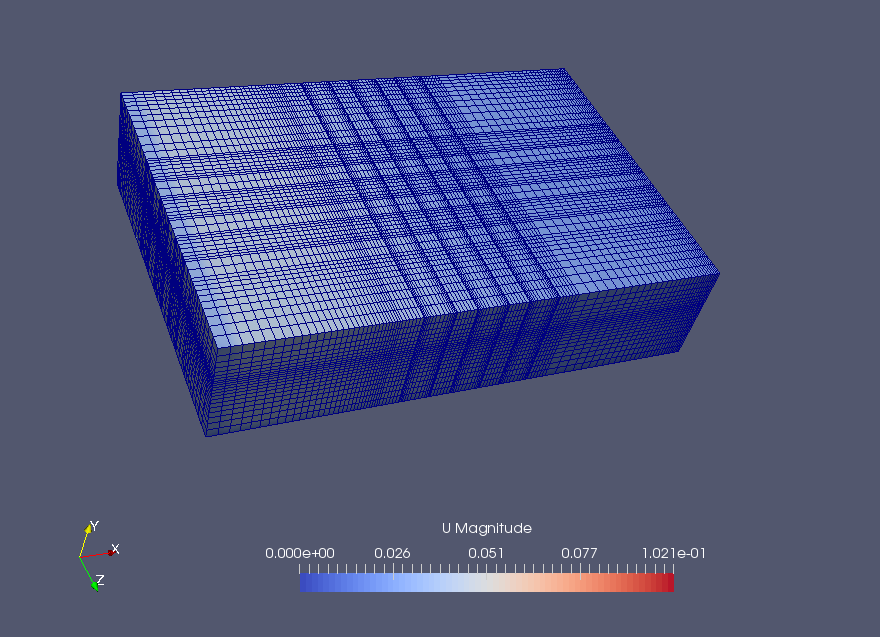

In [2]:
display(Image('../Figures/case1.png'))

In [ ]:
ls

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
%matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
p=p_fl
for i in p.reshape((p.shape[0]*p.shape[1]*p.shape[2],4)):
    legends = ['bottom','interface','total']
    ax.scatter(i[0],i[1],i[2],s=10)
    ax.text(i[0],i[1],i[2], "%d"%i[3], color='red',fontsize=10)

ax.view_init(-36,-136)
plt.show()

In [ ]:
pwd

In [12]:
a = np.arange(1,13)

In [13]:
a[4:10:2]

array([5, 7, 9])

In [28]:


"""def find_ncell_prog_from_cell_dim(l_1,n_cells,l,eps_target=1e-4):
    
    assert (l>l_1), "total length must be bigger than the first cell!"
    assert (n_cells>0), "Number of cells must be a posittive integer!"
    
    x_init = 0.99
    C = l/l_1
    eps = np.inf
    while (abs(eps)>eps_target):
        x_new = 1-C*(1-x_init**n_cells)
        eps = x_new - x_init
        x_init = x_new
    return x_new"""

In [27]:
(1-0.99**20)*10

1.8209306240276923

In [29]:
find_ncell_prog_from_cell_dim(0.1,20,1)

OverflowError: (34, 'Result too large')

In [31]:
find_cell_dim_from_prog(0.25,20,2)

(0.1833, 0.0458)

In [32]:
find_cell_dim_from_prog(0.25,10,2)

(0.3634, 0.0908)

In [33]:
find_cell_dim_from_prog(0.5,20,2)

(0.1383, 0.0692)

In [35]:
find_cell_dim_from_prog(0.25,40,4)

(0.1841, 0.046)

In [ ]:
 generate_z_coords(nBeamsZ,beamThicknessZ,zSpacing,sideWallTol)

In [ ]:
generate_x_coords(nBeamsX,beamThicknessX,xSpacing,lInlet,lOutlet)

In [2]:
if ((1+2)%2):
    print('choch')

choch


In [5]:
if ()

False

In [7]:
True and False

False

In [47]:
a

array([[[ 9., 10., 11., 12., 13., 14., 15., 16.],
        [ 9., 10., 11., 12., 13., 14., 15., 16.]],

       [[17., 18., 19., 20., 21., 22., 23., 24.],
        [25., 26., 27., 28., 29., 30., 31., 32.]],

       [[33., 34., 35., 36., 37., 38., 39., 40.],
        [41., 42., 43., 44., 45., 46., 47., 48.]]])

In [57]:
a.reshape((6,8))

array([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.],
       [ 9., 10., 11., 12., 13., 14., 15., 16.],
       [17., 18., 19., 20., 21., 22., 23., 24.],
       [25., 26., 27., 28., 29., 30., 31., 32.],
       [33., 34., 35., 36., 37., 38., 39., 40.],
       [41., 42., 43., 44., 45., 46., 47., 48.]])

In [93]:
b=np.ones((2,2,8))

In [94]:
b

array([[[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]],

       [[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]]])

In [95]:
a

array([[[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12., 13., 14., 15., 16.]],

       [[17., 18., 19., 20., 21., 22., 23., 24.],
        [25., 26., 27., 28., 29., 30., 31., 32.]],

       [[33., 34., 35., 36., 37., 38., 39., 40.],
        [41., 42., 43., 44., 45., 46., 47., 48.]],

       [[49., 50., 51., 52., 53., 54., 55., 56.],
        [57., 58., 59., 60., 61., 62., 63., 64.]]])

In [98]:
np.vstack((a,b)).shape

(6, 2, 8)

In [84]:
a=np.zeros((4,2,8))

In [85]:
a[0][0]=np.arange(1,9)

In [86]:
a[0][1]=np.arange(9,17)

In [87]:
a[1][0]=np.arange(17,25)

In [88]:
a[1][1]=np.arange(25,33)

In [89]:
a[2][0]=np.arange(33,41)

In [90]:
a[2][1]=np.arange(41,49)

In [91]:
a[3][0]=np.arange(49,57)

In [92]:
a[3][1]=np.arange(57,65)

In [83]:
a.reshape((8,8), order='F')[::2]

ValueError: cannot reshape array of size 3 into shape (8,8)

In [46]:
a.reshape((,-1), order='F')[::2]

array([[ 9., 34., 27., 13., 38., 31.],
       [33., 26., 12., 37., 30., 16.],
       [25., 11., 36., 29., 15., 40.],
       [10., 35., 28., 14., 39., 32.]])

In [44]:
a.reshape((6,-1))[1::2]

array([[ 9., 10., 11., 12., 13., 14., 15., 16.],
       [25., 26., 27., 28., 29., 30., 31., 32.],
       [41., 42., 43., 44., 45., 46., 47., 48.]])

In [43]:
a.reshape((6,-1), order='F')[1::2]

array([[17., 18., 19., 20., 21., 22., 23., 24.],
       [ 9., 10., 11., 12., 13., 14., 15., 16.],
       [41., 42., 43., 44., 45., 46., 47., 48.]])

In [76]:
import numpy as np
a=np.array([1,2,3])
b=np.array([1,2,3])
c=[]
c.append(a)
c.append(b)

In [80]:
type(np.reshape(c,(2,-1)))

numpy.ndarray

In [82]:
np.asarray(c).shape

(2, 3)

In [22]:
import numpy as np
a = np.array([[1,2,3], [4,5,6], [7,8,9], [10,11,12]])
np.reshape(a, 12, order='F')[::2]

array([1, 7, 2, 8, 3, 9])

In [23]:
np.reshape(a, 12, order='F')[1::2]

array([ 4, 10,  5, 11,  6, 12])

In [19]:
np.reshape(blocks, 12, order='F')[::2]

NameError: name 'blocks' is not defined